In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:cores",
    "device": "cuda",
    "lr": 0.0001,
    "labels": [
        "1-10.",
        "1-11.",
        "1-15.",
        "1-16.",
        "1-17.",
        "1-18.",
        "1-19.",
        "10-4.",
        "10-7.",
        "11-1.",
        "11-14.",
        "11-17.",
        "11-20.",
        "11-7.",
        "13-20.",
        "13-8.",
        "14-10.",
        "14-11.",
        "14-14.",
        "14-7.",
        "15-1.",
        "15-20.",
        "16-1.",
        "16-16.",
        "17-10.",
        "17-11.",
        "17-2.",
        "19-1.",
        "19-16.",
        "19-19.",
        "19-20.",
        "19-3.",
        "2-10.",
        "2-11.",
        "2-17.",
        "2-18.",
        "2-20.",
        "2-3.",
        "2-4.",
        "2-5.",
        "2-6.",
        "2-7.",
        "2-8.",
        "3-13.",
        "3-18.",
        "3-3.",
        "4-1.",
        "4-10.",
        "4-11.",
        "4-19.",
        "5-5.",
        "6-15.",
        "7-10.",
        "7-14.",
        "8-18.",
        "8-20.",
        "8-3.",
        "8-8.",
    ],
    "batch_size": 128,
    "domains_source": [1, 2, 3, 4, 5],
    "domains_target": [1, 2, 3, 4, 5],
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 58}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name_source": "cores.stratified_ds.2022A.pkl",
    "pickle_name_target": "cores.stratified_ds.2022A.pkl",
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1370], examples_per_second: 751.4990, train_label_loss: 3.9914, 


epoch: 1, [batch: 137 / 1370], examples_per_second: 11707.3029, train_label_loss: 1.7434, 


epoch: 1, [batch: 274 / 1370], examples_per_second: 11672.8294, train_label_loss: 0.8787, 


epoch: 1, [batch: 411 / 1370], examples_per_second: 11662.2537, train_label_loss: 0.4223, 


epoch: 1, [batch: 548 / 1370], examples_per_second: 11654.5127, train_label_loss: 0.2911, 


epoch: 1, [batch: 685 / 1370], examples_per_second: 11564.9831, train_label_loss: 0.1721, 


epoch: 1, [batch: 822 / 1370], examples_per_second: 11673.1665, train_label_loss: 0.2239, 


epoch: 1, [batch: 959 / 1370], examples_per_second: 11711.6870, train_label_loss: 0.1256, 


epoch: 1, [batch: 1096 / 1370], examples_per_second: 11565.9179, train_label_loss: 0.0768, 


epoch: 1, [batch: 1233 / 1370], examples_per_second: 11641.8986, train_label_loss: 0.0886, 


epoch: 1, source_val_acc_label: 0.9921, source_val_label_loss: 0.0646, target_val_acc_label: 0.9921, target_val_label_loss: 0.0647, 


New best
epoch: 2, [batch: 1 / 1370], examples_per_second: 57.9986, train_label_loss: 0.0590, 


epoch: 2, [batch: 137 / 1370], examples_per_second: 11555.6939, train_label_loss: 0.0402, 


epoch: 2, [batch: 274 / 1370], examples_per_second: 11608.7342, train_label_loss: 0.0554, 


epoch: 2, [batch: 411 / 1370], examples_per_second: 11601.6405, train_label_loss: 0.0656, 


epoch: 2, [batch: 548 / 1370], examples_per_second: 11496.3323, train_label_loss: 0.0238, 


epoch: 2, [batch: 685 / 1370], examples_per_second: 11547.9530, train_label_loss: 0.0230, 


epoch: 2, [batch: 822 / 1370], examples_per_second: 11613.4193, train_label_loss: 0.0442, 


epoch: 2, [batch: 959 / 1370], examples_per_second: 11552.0485, train_label_loss: 0.0167, 


epoch: 2, [batch: 1096 / 1370], examples_per_second: 11579.1078, train_label_loss: 0.0330, 


epoch: 2, [batch: 1233 / 1370], examples_per_second: 11638.7281, train_label_loss: 0.0276, 


epoch: 2, source_val_acc_label: 0.9907, source_val_label_loss: 0.0386, target_val_acc_label: 0.9907, target_val_label_loss: 0.0386, 


epoch: 3, [batch: 1 / 1370], examples_per_second: 65.3464, train_label_loss: 0.0279, 


epoch: 3, [batch: 137 / 1370], examples_per_second: 11575.9310, train_label_loss: 0.0088, 


epoch: 3, [batch: 274 / 1370], examples_per_second: 11557.9500, train_label_loss: 0.0130, 


epoch: 3, [batch: 411 / 1370], examples_per_second: 11631.9896, train_label_loss: 0.0120, 


epoch: 3, [batch: 548 / 1370], examples_per_second: 11509.3351, train_label_loss: 0.0106, 


epoch: 3, [batch: 685 / 1370], examples_per_second: 11562.0289, train_label_loss: 0.0310, 


epoch: 3, [batch: 822 / 1370], examples_per_second: 11520.7286, train_label_loss: 0.0482, 


epoch: 3, [batch: 959 / 1370], examples_per_second: 11455.3974, train_label_loss: 0.0043, 


epoch: 3, [batch: 1096 / 1370], examples_per_second: 11438.8075, train_label_loss: 0.0095, 


epoch: 3, [batch: 1233 / 1370], examples_per_second: 11567.5604, train_label_loss: 0.0106, 


epoch: 3, source_val_acc_label: 0.9933, source_val_label_loss: 0.0288, target_val_acc_label: 0.9933, target_val_label_loss: 0.0288, 


New best
epoch: 4, [batch: 1 / 1370], examples_per_second: 65.9602, train_label_loss: 0.0042, 


epoch: 4, [batch: 137 / 1370], examples_per_second: 11509.7005, train_label_loss: 0.0028, 


epoch: 4, [batch: 274 / 1370], examples_per_second: 11640.1059, train_label_loss: 0.0894, 


epoch: 4, [batch: 411 / 1370], examples_per_second: 11461.3810, train_label_loss: 0.0039, 


epoch: 4, [batch: 548 / 1370], examples_per_second: 11536.1546, train_label_loss: 0.0070, 


epoch: 4, [batch: 685 / 1370], examples_per_second: 11636.9070, train_label_loss: 0.0196, 


epoch: 4, [batch: 822 / 1370], examples_per_second: 11578.7505, train_label_loss: 0.0066, 


epoch: 4, [batch: 959 / 1370], examples_per_second: 11608.5419, train_label_loss: 0.0041, 


epoch: 4, [batch: 1096 / 1370], examples_per_second: 11625.9111, train_label_loss: 0.0168, 


epoch: 4, [batch: 1233 / 1370], examples_per_second: 11610.1196, train_label_loss: 0.0123, 


epoch: 4, source_val_acc_label: 0.9580, source_val_label_loss: 0.1782, target_val_acc_label: 0.9580, target_val_label_loss: 0.1784, 


epoch: 5, [batch: 1 / 1370], examples_per_second: 65.6681, train_label_loss: 0.0016, 


epoch: 5, [batch: 137 / 1370], examples_per_second: 11601.5033, train_label_loss: 0.0074, 


epoch: 5, [batch: 274 / 1370], examples_per_second: 11744.7303, train_label_loss: 0.0036, 


epoch: 5, [batch: 411 / 1370], examples_per_second: 11712.8340, train_label_loss: 0.0066, 


epoch: 5, [batch: 548 / 1370], examples_per_second: 11728.4500, train_label_loss: 0.0018, 


epoch: 5, [batch: 685 / 1370], examples_per_second: 11708.0684, train_label_loss: 0.0023, 


epoch: 5, [batch: 822 / 1370], examples_per_second: 11707.3584, train_label_loss: 0.0088, 


epoch: 5, [batch: 959 / 1370], examples_per_second: 11699.8291, train_label_loss: 0.0020, 


epoch: 5, [batch: 1096 / 1370], examples_per_second: 11655.4694, train_label_loss: 0.0065, 


epoch: 5, [batch: 1233 / 1370], examples_per_second: 11678.2486, train_label_loss: 0.0064, 


epoch: 5, source_val_acc_label: 0.9790, source_val_label_loss: 0.0641, target_val_acc_label: 0.9790, target_val_label_loss: 0.0641, 


epoch: 6, [batch: 1 / 1370], examples_per_second: 65.7799, train_label_loss: 0.0088, 


epoch: 6, [batch: 137 / 1370], examples_per_second: 11714.3822, train_label_loss: 0.0016, 


epoch: 6, [batch: 274 / 1370], examples_per_second: 11683.5245, train_label_loss: 0.0008, 


epoch: 6, [batch: 411 / 1370], examples_per_second: 11676.4169, train_label_loss: 0.0008, 


epoch: 6, [batch: 548 / 1370], examples_per_second: 11776.0353, train_label_loss: 0.0021, 


epoch: 6, [batch: 685 / 1370], examples_per_second: 11671.2790, train_label_loss: 0.0185, 


epoch: 6, [batch: 822 / 1370], examples_per_second: 11707.0732, train_label_loss: 0.0018, 


epoch: 6, [batch: 959 / 1370], examples_per_second: 11677.9909, train_label_loss: 0.0046, 


epoch: 6, [batch: 1096 / 1370], examples_per_second: 11606.4023, train_label_loss: 0.0021, 


epoch: 6, [batch: 1233 / 1370], examples_per_second: 11672.9479, train_label_loss: 0.0015, 


epoch: 6, source_val_acc_label: 0.9974, source_val_label_loss: 0.0104, target_val_acc_label: 0.9974, target_val_label_loss: 0.0104, 


New best
epoch: 7, [batch: 1 / 1370], examples_per_second: 65.8481, train_label_loss: 0.0006, 


epoch: 7, [batch: 137 / 1370], examples_per_second: 11554.0354, train_label_loss: 0.0013, 


epoch: 7, [batch: 274 / 1370], examples_per_second: 11661.5473, train_label_loss: 0.0010, 


epoch: 7, [batch: 411 / 1370], examples_per_second: 11770.7171, train_label_loss: 0.0027, 


epoch: 7, [batch: 548 / 1370], examples_per_second: 11745.7169, train_label_loss: 0.0013, 


epoch: 7, [batch: 685 / 1370], examples_per_second: 11723.8249, train_label_loss: 0.0035, 


epoch: 7, [batch: 822 / 1370], examples_per_second: 11727.0587, train_label_loss: 0.0081, 


epoch: 7, [batch: 959 / 1370], examples_per_second: 11759.0289, train_label_loss: 0.0042, 


epoch: 7, [batch: 1096 / 1370], examples_per_second: 11700.3037, train_label_loss: 0.0005, 


epoch: 7, [batch: 1233 / 1370], examples_per_second: 11675.0547, train_label_loss: 0.0025, 


epoch: 7, source_val_acc_label: 0.9975, source_val_label_loss: 0.0094, target_val_acc_label: 0.9975, target_val_label_loss: 0.0094, 


New best
epoch: 8, [batch: 1 / 1370], examples_per_second: 66.0942, train_label_loss: 0.0003, 


epoch: 8, [batch: 137 / 1370], examples_per_second: 11587.2971, train_label_loss: 0.0167, 


epoch: 8, [batch: 274 / 1370], examples_per_second: 11706.6111, train_label_loss: 0.0013, 


epoch: 8, [batch: 411 / 1370], examples_per_second: 11699.2299, train_label_loss: 0.0006, 


epoch: 8, [batch: 548 / 1370], examples_per_second: 11705.8081, train_label_loss: 0.0002, 


epoch: 8, [batch: 685 / 1370], examples_per_second: 11716.2857, train_label_loss: 0.0004, 


epoch: 8, [batch: 822 / 1370], examples_per_second: 11701.8022, train_label_loss: 0.0009, 


epoch: 8, [batch: 959 / 1370], examples_per_second: 11699.0531, train_label_loss: 0.0012, 


epoch: 8, [batch: 1096 / 1370], examples_per_second: 11689.3587, train_label_loss: 0.0005, 


epoch: 8, [batch: 1233 / 1370], examples_per_second: 11678.4823, train_label_loss: 0.0044, 


epoch: 8, source_val_acc_label: 0.9967, source_val_label_loss: 0.0129, target_val_acc_label: 0.9967, target_val_label_loss: 0.0128, 


epoch: 9, [batch: 1 / 1370], examples_per_second: 66.2402, train_label_loss: 0.0007, 


epoch: 9, [batch: 137 / 1370], examples_per_second: 11585.6791, train_label_loss: 0.0013, 


epoch: 9, [batch: 274 / 1370], examples_per_second: 11687.1316, train_label_loss: 0.0029, 


epoch: 9, [batch: 411 / 1370], examples_per_second: 11660.7561, train_label_loss: 0.0006, 


epoch: 9, [batch: 548 / 1370], examples_per_second: 11635.6883, train_label_loss: 0.0021, 


epoch: 9, [batch: 685 / 1370], examples_per_second: 11674.9249, train_label_loss: 0.0011, 


epoch: 9, [batch: 822 / 1370], examples_per_second: 11693.6294, train_label_loss: 0.0022, 


epoch: 9, [batch: 959 / 1370], examples_per_second: 11691.4509, train_label_loss: 0.0003, 


epoch: 9, [batch: 1096 / 1370], examples_per_second: 11627.7766, train_label_loss: 0.0003, 


epoch: 9, [batch: 1233 / 1370], examples_per_second: 11648.4716, train_label_loss: 0.0068, 


epoch: 9, source_val_acc_label: 0.9972, source_val_label_loss: 0.0114, target_val_acc_label: 0.9972, target_val_label_loss: 0.0114, 


epoch: 10, [batch: 1 / 1370], examples_per_second: 66.7852, train_label_loss: 0.0038, 


epoch: 10, [batch: 137 / 1370], examples_per_second: 11699.2009, train_label_loss: 0.0003, 


epoch: 10, [batch: 274 / 1370], examples_per_second: 11670.1253, train_label_loss: 0.0014, 


epoch: 10, [batch: 411 / 1370], examples_per_second: 12371.1235, train_label_loss: 0.0006, 


epoch: 10, [batch: 548 / 1370], examples_per_second: 12607.9373, train_label_loss: 0.0007, 


epoch: 10, [batch: 685 / 1370], examples_per_second: 12310.5543, train_label_loss: 0.0002, 


epoch: 10, [batch: 822 / 1370], examples_per_second: 12727.4905, train_label_loss: 0.0043, 


epoch: 10, [batch: 959 / 1370], examples_per_second: 13026.8085, train_label_loss: 0.0003, 


epoch: 10, [batch: 1096 / 1370], examples_per_second: 12676.4092, train_label_loss: 0.0003, 


epoch: 10, [batch: 1233 / 1370], examples_per_second: 12578.2884, train_label_loss: 0.0029, 


epoch: 10, source_val_acc_label: 0.9977, source_val_label_loss: 0.0095, target_val_acc_label: 0.9977, target_val_label_loss: 0.0096, 


New best
epoch: 11, [batch: 1 / 1370], examples_per_second: 72.0449, train_label_loss: 0.0016, 


epoch: 11, [batch: 137 / 1370], examples_per_second: 12627.0748, train_label_loss: 0.0004, 


epoch: 11, [batch: 274 / 1370], examples_per_second: 12546.0515, train_label_loss: 0.0006, 


epoch: 11, [batch: 411 / 1370], examples_per_second: 12558.3539, train_label_loss: 0.0004, 


epoch: 11, [batch: 548 / 1370], examples_per_second: 12493.5096, train_label_loss: 0.0006, 


epoch: 11, [batch: 685 / 1370], examples_per_second: 12569.5160, train_label_loss: 0.0001, 


epoch: 11, [batch: 822 / 1370], examples_per_second: 12560.9104, train_label_loss: 0.0023, 


epoch: 11, [batch: 959 / 1370], examples_per_second: 12649.4870, train_label_loss: 0.0011, 


epoch: 11, [batch: 1096 / 1370], examples_per_second: 12727.7218, train_label_loss: 0.0006, 


epoch: 11, [batch: 1233 / 1370], examples_per_second: 12553.9019, train_label_loss: 0.0001, 


epoch: 11, source_val_acc_label: 0.9959, source_val_label_loss: 0.0150, target_val_acc_label: 0.9959, target_val_label_loss: 0.0149, 


epoch: 12, [batch: 1 / 1370], examples_per_second: 72.6120, train_label_loss: 0.0003, 


epoch: 12, [batch: 137 / 1370], examples_per_second: 12328.6207, train_label_loss: 0.0003, 


epoch: 12, [batch: 274 / 1370], examples_per_second: 12577.9378, train_label_loss: 0.0010, 


epoch: 12, [batch: 411 / 1370], examples_per_second: 12635.5380, train_label_loss: 0.0001, 


epoch: 12, [batch: 548 / 1370], examples_per_second: 12686.1738, train_label_loss: 0.0001, 


epoch: 12, [batch: 685 / 1370], examples_per_second: 12689.6801, train_label_loss: 0.0001, 


epoch: 12, [batch: 822 / 1370], examples_per_second: 12589.1025, train_label_loss: 0.0002, 


epoch: 12, [batch: 959 / 1370], examples_per_second: 12573.7943, train_label_loss: 0.0001, 


epoch: 12, [batch: 1096 / 1370], examples_per_second: 12647.2858, train_label_loss: 0.0003, 


epoch: 12, [batch: 1233 / 1370], examples_per_second: 12588.1200, train_label_loss: 0.0005, 


epoch: 12, source_val_acc_label: 0.9971, source_val_label_loss: 0.0127, target_val_acc_label: 0.9971, target_val_label_loss: 0.0126, 


epoch: 13, [batch: 1 / 1370], examples_per_second: 73.6949, train_label_loss: 0.0005, 


epoch: 13, [batch: 137 / 1370], examples_per_second: 12632.2611, train_label_loss: 0.0001, 


epoch: 13, [batch: 274 / 1370], examples_per_second: 12643.7311, train_label_loss: 0.0005, 


epoch: 13, [batch: 411 / 1370], examples_per_second: 12528.2075, train_label_loss: 0.0001, 


epoch: 13, [batch: 548 / 1370], examples_per_second: 12517.9345, train_label_loss: 0.0006, 


epoch: 13, [batch: 685 / 1370], examples_per_second: 12507.7911, train_label_loss: 0.0001, 


epoch: 13, [batch: 822 / 1370], examples_per_second: 12500.5060, train_label_loss: 0.0000, 


epoch: 13, [batch: 959 / 1370], examples_per_second: 12478.8499, train_label_loss: 0.0001, 


epoch: 13, [batch: 1096 / 1370], examples_per_second: 12607.8314, train_label_loss: 0.0025, 


epoch: 13, [batch: 1233 / 1370], examples_per_second: 12633.9406, train_label_loss: 0.0019, 


epoch: 13, source_val_acc_label: 0.9978, source_val_label_loss: 0.0085, target_val_acc_label: 0.9978, target_val_label_loss: 0.0085, 


New best
epoch: 14, [batch: 1 / 1370], examples_per_second: 71.8487, train_label_loss: 0.0003, 


epoch: 14, [batch: 137 / 1370], examples_per_second: 12525.5791, train_label_loss: 0.0027, 


epoch: 14, [batch: 274 / 1370], examples_per_second: 12582.3100, train_label_loss: 0.0007, 


epoch: 14, [batch: 411 / 1370], examples_per_second: 12593.8188, train_label_loss: 0.0001, 


epoch: 14, [batch: 548 / 1370], examples_per_second: 12545.5765, train_label_loss: 0.0015, 


epoch: 14, [batch: 685 / 1370], examples_per_second: 12523.9197, train_label_loss: 0.0003, 


epoch: 14, [batch: 822 / 1370], examples_per_second: 12866.5236, train_label_loss: 0.0009, 


epoch: 14, [batch: 959 / 1370], examples_per_second: 12586.7348, train_label_loss: 0.0007, 


epoch: 14, [batch: 1096 / 1370], examples_per_second: 12602.2192, train_label_loss: 0.0004, 


epoch: 14, [batch: 1233 / 1370], examples_per_second: 12574.9702, train_label_loss: 0.0001, 


epoch: 14, source_val_acc_label: 0.9985, source_val_label_loss: 0.0063, target_val_acc_label: 0.9985, target_val_label_loss: 0.0063, 


New best
epoch: 15, [batch: 1 / 1370], examples_per_second: 71.7856, train_label_loss: 0.0001, 


epoch: 15, [batch: 137 / 1370], examples_per_second: 12513.5812, train_label_loss: 0.0009, 


epoch: 15, [batch: 274 / 1370], examples_per_second: 12671.2007, train_label_loss: 0.0002, 


epoch: 15, [batch: 411 / 1370], examples_per_second: 12661.8166, train_label_loss: 0.0002, 


epoch: 15, [batch: 548 / 1370], examples_per_second: 12577.5678, train_label_loss: 0.0001, 


epoch: 15, [batch: 685 / 1370], examples_per_second: 12632.9988, train_label_loss: 0.0001, 


epoch: 15, [batch: 822 / 1370], examples_per_second: 12652.0393, train_label_loss: 0.0001, 


epoch: 15, [batch: 959 / 1370], examples_per_second: 12701.9917, train_label_loss: 0.0003, 


epoch: 15, [batch: 1096 / 1370], examples_per_second: 12628.1923, train_label_loss: 0.0002, 


epoch: 15, [batch: 1233 / 1370], examples_per_second: 12571.5721, train_label_loss: 0.0003, 


epoch: 15, source_val_acc_label: 0.9983, source_val_label_loss: 0.0085, target_val_acc_label: 0.9983, target_val_label_loss: 0.0085, 


epoch: 16, [batch: 1 / 1370], examples_per_second: 70.6380, train_label_loss: 0.0006, 


epoch: 16, [batch: 137 / 1370], examples_per_second: 12604.6334, train_label_loss: 0.0000, 


epoch: 16, [batch: 274 / 1370], examples_per_second: 12633.4480, train_label_loss: 0.0001, 


epoch: 16, [batch: 411 / 1370], examples_per_second: 12482.9057, train_label_loss: 0.0001, 


epoch: 16, [batch: 548 / 1370], examples_per_second: 12607.8639, train_label_loss: 0.0005, 


epoch: 16, [batch: 685 / 1370], examples_per_second: 12354.2651, train_label_loss: 0.0004, 


epoch: 16, [batch: 822 / 1370], examples_per_second: 12722.7791, train_label_loss: 0.0008, 


epoch: 16, [batch: 959 / 1370], examples_per_second: 12730.1758, train_label_loss: 0.0002, 


epoch: 16, [batch: 1096 / 1370], examples_per_second: 12609.4569, train_label_loss: 0.0001, 


epoch: 16, [batch: 1233 / 1370], examples_per_second: 12594.3493, train_label_loss: 0.0001, 


epoch: 16, source_val_acc_label: 0.9983, source_val_label_loss: 0.0077, target_val_acc_label: 0.9983, target_val_label_loss: 0.0077, 


epoch: 17, [batch: 1 / 1370], examples_per_second: 73.3936, train_label_loss: 0.0001, 


epoch: 17, [batch: 137 / 1370], examples_per_second: 12659.5449, train_label_loss: 0.0000, 


epoch: 17, [batch: 274 / 1370], examples_per_second: 12261.9961, train_label_loss: 0.0000, 


epoch: 17, [batch: 411 / 1370], examples_per_second: 12557.8264, train_label_loss: 0.0001, 


epoch: 17, [batch: 548 / 1370], examples_per_second: 12535.5463, train_label_loss: 0.0003, 


epoch: 17, [batch: 685 / 1370], examples_per_second: 12610.4492, train_label_loss: 0.0001, 


epoch: 17, [batch: 822 / 1370], examples_per_second: 12496.7213, train_label_loss: 0.0004, 


epoch: 17, [batch: 959 / 1370], examples_per_second: 12434.8833, train_label_loss: 0.0001, 


epoch: 17, [batch: 1096 / 1370], examples_per_second: 12540.4193, train_label_loss: 0.0066, 


epoch: 17, [batch: 1233 / 1370], examples_per_second: 12666.3586, train_label_loss: 0.0005, 


epoch: 17, source_val_acc_label: 0.9972, source_val_label_loss: 0.0129, target_val_acc_label: 0.9972, target_val_label_loss: 0.0128, 


epoch: 18, [batch: 1 / 1370], examples_per_second: 73.3921, train_label_loss: 0.0001, 


epoch: 18, [batch: 137 / 1370], examples_per_second: 12560.0128, train_label_loss: 0.0002, 


epoch: 18, [batch: 274 / 1370], examples_per_second: 12726.9686, train_label_loss: 0.0001, 


epoch: 18, [batch: 411 / 1370], examples_per_second: 12658.6415, train_label_loss: 0.0001, 


epoch: 18, [batch: 548 / 1370], examples_per_second: 12561.1249, train_label_loss: 0.0003, 


epoch: 18, [batch: 685 / 1370], examples_per_second: 12513.7453, train_label_loss: 0.0001, 


epoch: 18, [batch: 822 / 1370], examples_per_second: 12508.9164, train_label_loss: 0.0003, 


epoch: 18, [batch: 959 / 1370], examples_per_second: 12655.4049, train_label_loss: 0.0002, 


epoch: 18, [batch: 1096 / 1370], examples_per_second: 12658.2319, train_label_loss: 0.0002, 


epoch: 18, [batch: 1233 / 1370], examples_per_second: 12693.7952, train_label_loss: 0.0062, 


epoch: 18, source_val_acc_label: 0.9980, source_val_label_loss: 0.0093, target_val_acc_label: 0.9980, target_val_label_loss: 0.0093, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

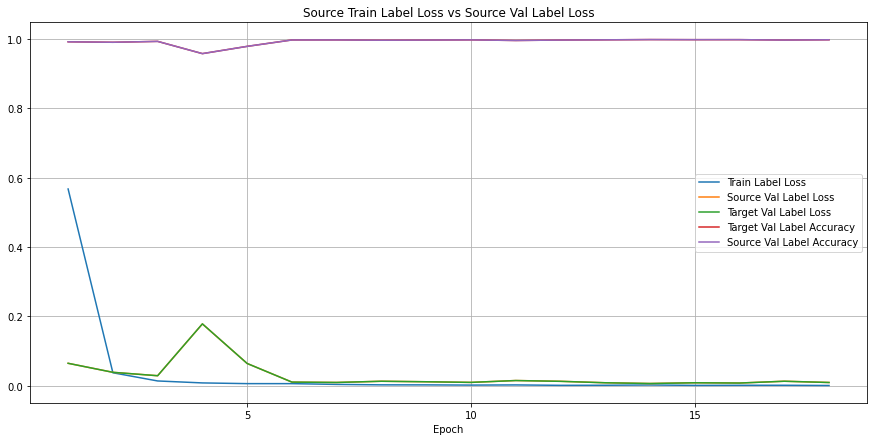

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

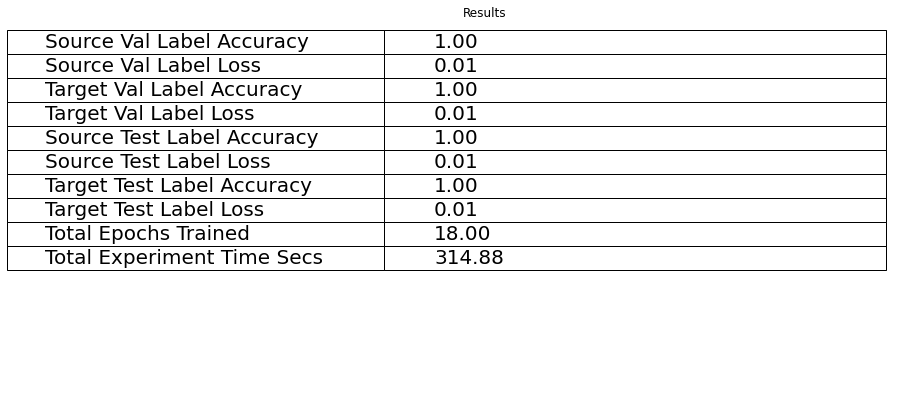

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

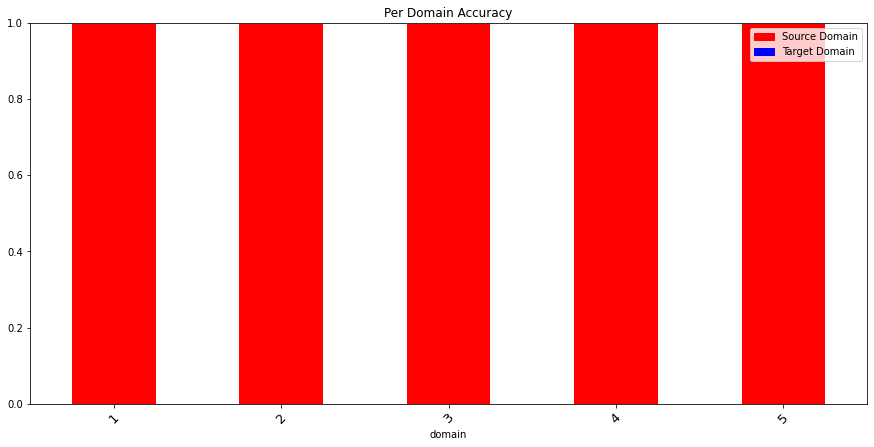

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9979668893406912 Target Test Label Accuracy: 0.9979668893406912
Source Val Label Accuracy: 0.9985317280226381 Target Val Label Accuracy: 0.9985317280226381


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:cores", "parameters": {"experiment_name": "cnn_2:cores", "device": "cuda", "lr": 0.0001, "labels": ["1-10.", "1-11.", "1-15.", "1-16.", "1-17.", "1-18.", "1-19.", "10-4.", "10-7.", "11-1.", "11-14.", "11-17.", "11-20.", "11-7.", "13-20.", "13-8.", "14-10.", "14-11.", "14-14.", "14-7.", "15-1.", "15-20.", "16-1.", "16-16.", "17-10.", "17-11.", "17-2.", "19-1.", "19-16.", "19-19.", "19-20.", "19-3.", "2-10.", "2-11.", "2-17.", "2-18.", "2-20.", "2-3.", "2-4.", "2-5.", "2-6.", "2-7.", "2-8.", "3-13.", "3-18.", "3-3.", "4-1.", "4-10.", "4-11.", "4-19.", "5-5.", "6-15.", "7-10.", "7-14.", "8-18.", "8-20.", "8-3.", "8-8."], "batch_size": 128, "domains_source": [1, 2, 3, 4, 5], "domains_target": [1, 2, 3, 4, 5], "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy